# Introdução à Aprendizagem de Máquina - Trabalho Final

## 1. A base de dados "A Large Scale Fish Dataset"

In [68]:
import kaggle
import pathlib

In [70]:
wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
kaggle.api.dataset_download_files('crowww/a-large-scale-fish-dataset', path=wd+'/dataset/a-large-scale-fish-dataset', unzip=True)
kaggle.api.dataset_download_files('alxmamaev/flowers-recognition', path=wd+'/dataset/flowers-recognition', unzip=True)
kaggle.api.dataset_download_files('moltean/fruits', path=wd+'/dataset/fruits', unzip=True)

## 2. Implementação original do baseline, utilizando MobileNet v2, implementado em Keras

In [71]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [83]:
image_dir = Path('dataset/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]
image_df

,Filepath,Label
0,dataset/a-large-scale-fish-dataset/Fish_Datase...,Black Sea Sprat
1,dataset/a-large-scale-fish-dataset/Fish_Datase...,Black Sea Sprat
2,dataset/a-large-scale-fish-dataset/Fish_Datase...,Black Sea Sprat
3,dataset/a-large-scale-fish-dataset/Fish_Datase...,Black Sea Sprat
4,dataset/a-large-scale-fish-dataset/Fish_Datase...,Black Sea Sprat
...,...,...
16995,dataset/a-large-scale-fish-dataset/Fish_Datase...,Trout
16996,dataset/a-large-scale-fish-dataset/Fish_Datase...,Trout
16997,dataset/a-large-scale-fish-dataset/Fish_Datase...,Trout
16998,dataset/a-large-scale-fish-dataset/Fish_Datase...,Trout


In [84]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/a-large-scale-fish-dataset/Fish_Datase...,Red Sea Bream
1,dataset/a-large-scale-fish-dataset/Fish_Datase...,Sea Bass
2,dataset/a-large-scale-fish-dataset/Fish_Datase...,Sea Bass


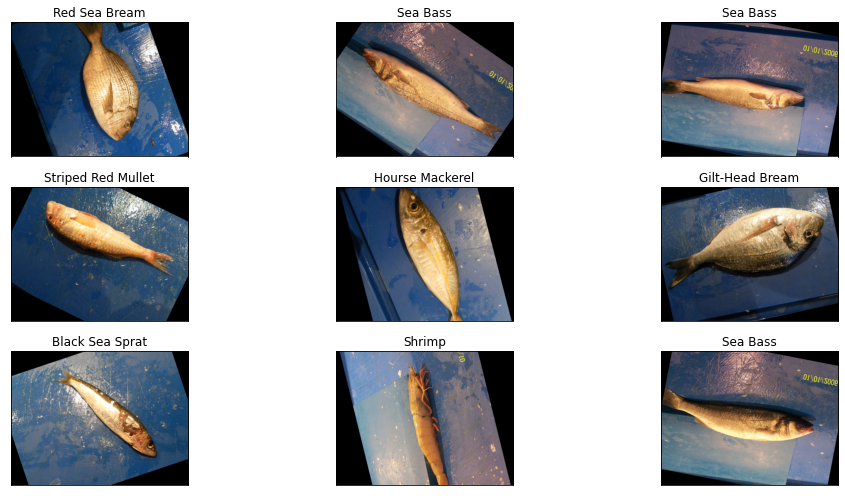

In [85]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [86]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [87]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [88]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [89]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [90]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 177s 856ms/step - loss: 0.4648 - accuracy: 0.8596 - val_loss: 0.0395 - val_accuracy: 0.9877
Epoch 2/50
203/203 [==============================] - 158s 776ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 0.0444 - val_accuracy: 0.9858
Epoch 3/50
203/203 [==============================] - 159s 784ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0086 - val_accuracy: 0.9969
Epoch 4/50
203/203 [==============================] - 155s 762ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0134 - val_accuracy: 0.9975
Epoch 5/50
203/203 [==============================] - 156s 766ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0033 - val_accuracy: 0.9988
Epoch 6/50
203/203 [==============================] - 154s 758ms/step - loss: 4.3839e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9988
Epoch 7/50
203/203 [==============================] - 155s 761ms/step - loss: 1.4767e-04 - accuracy: 1.0000 - val_loss: 

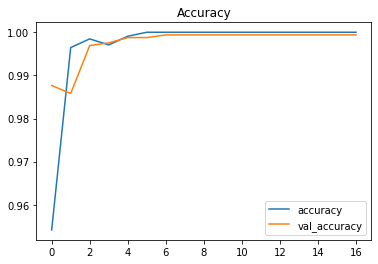

In [91]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

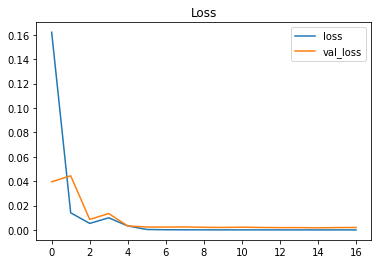

In [92]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [93]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00088
Test Accuracy: 100.00%


In [94]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Striped Red Mullet', 'Gilt-Head Bream', 'Red Sea Bream', 'Red Sea Bream', 'Shrimp']


In [95]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        99
   Gilt-Head Bream       1.00      1.00      1.00        93
   Hourse Mackerel       1.00      1.00      1.00        83
        Red Mullet       1.00      1.00      1.00       112
     Red Sea Bream       1.00      1.00      1.00        98
          Sea Bass       1.00      1.00      1.00       108
            Shrimp       1.00      1.00      1.00       101
Striped Red Mullet       1.00      1.00      1.00       103
             Trout       1.00      1.00      1.00       103

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



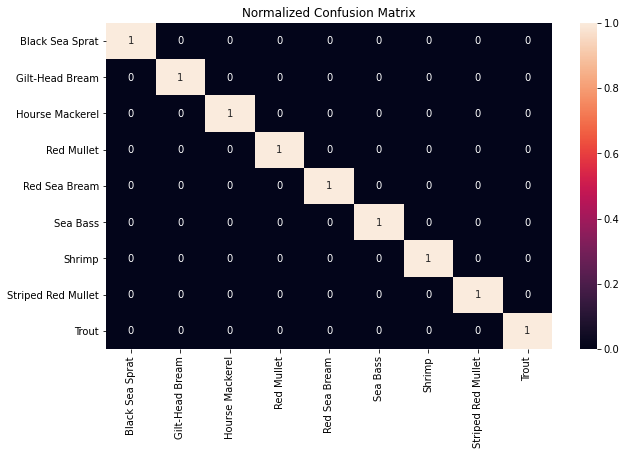

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

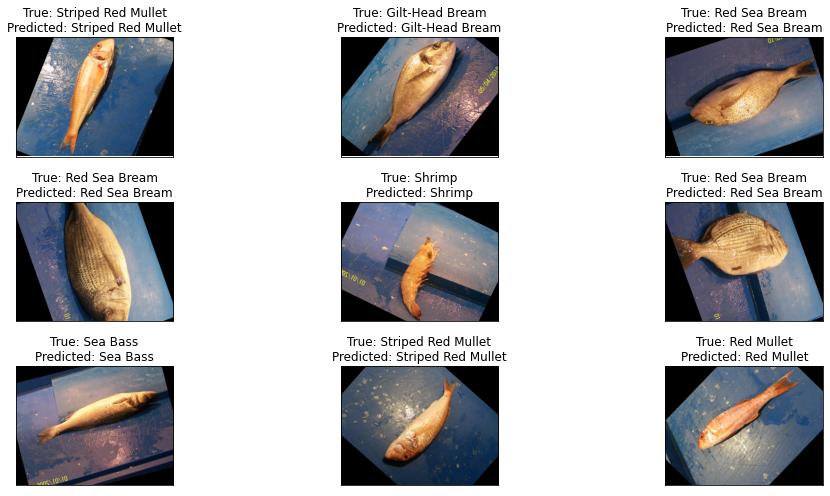

In [97]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 3. Implementação do baseline, utilizando DenseNet implementado em PyTorch

## 4. Aplicando a implementação original ao dataset "flowers-recognition"

In [99]:
image_dir = Path('dataset/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,dataset/flowers-recognition/flowers/daisy/1000...,daisy
1,dataset/flowers-recognition/flowers/daisy/1014...,daisy
2,dataset/flowers-recognition/flowers/daisy/1017...,daisy
3,dataset/flowers-recognition/flowers/daisy/1017...,daisy
4,dataset/flowers-recognition/flowers/daisy/1017...,daisy
...,...,...
8641,dataset/flowers-recognition/flowers/tulip/9831...,tulip
8642,dataset/flowers-recognition/flowers/tulip/9870...,tulip
8643,dataset/flowers-recognition/flowers/tulip/9947...,tulip
8644,dataset/flowers-recognition/flowers/tulip/9947...,tulip


In [100]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/flowers-recognition/flowers/tulip/1427...,tulip
1,dataset/flowers-recognition/flowers/flowers/da...,daisy
2,dataset/flowers-recognition/flowers/dandelion/...,dandelion


In [111]:
import cv2

In [115]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [142]:
IMG_SIZE = 224
resized = []
for path in image_df['Filepath']:
    img_arr = cv2.imread(path, cv2.IMREAD_COLOR)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    resized.append([resized_arr])

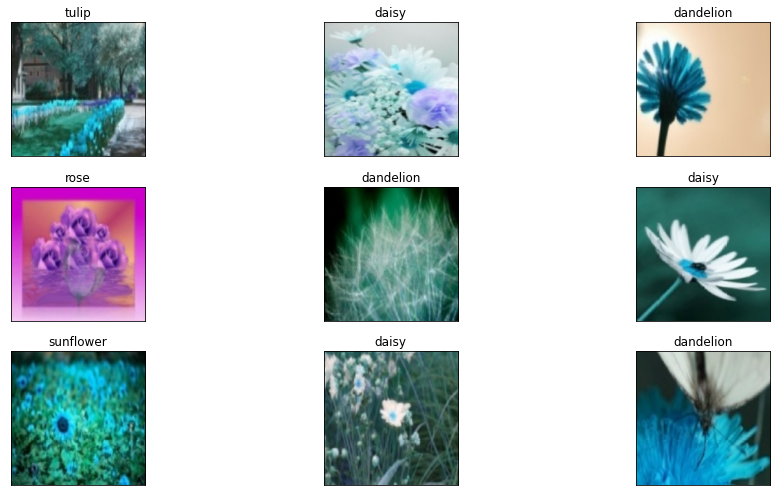

In [143]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(resized[i][0])
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [144]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [145]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [146]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6225 validated image filenames belonging to 5 classes.
Found 1556 validated image filenames belonging to 5 classes.
Found 865 validated image filenames belonging to 5 classes.


In [147]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [149]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # 5 is the number of labels

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
195/195 [==============================] - 236s 1s/step - loss: 0.7417 - accuracy: 0.7221 - val_loss: 0.3495 - val_accuracy: 0.8734
Epoch 2/50
195/195 [==============================] - 120s 613ms/step - loss: 0.2836 - accuracy: 0.9036 - val_loss: 0.2636 - val_accuracy: 0.9120
Epoch 3/50
195/195 [==============================] - 110s 564ms/step - loss: 0.1550 - accuracy: 0.9496 - val_loss: 0.2423 - val_accuracy: 0.9248
Epoch 4/50
195/195 [==============================] - 122s 626ms/step - loss: 0.0929 - accuracy: 0.9729 - val_loss: 0.1754 - val_accuracy: 0.9473
Epoch 5/50
195/195 [==============================] - 113s 577ms/step - loss: 0.0441 - accuracy: 0.9868 - val_loss: 0.1747 - val_accuracy: 0.9557
Epoch 6/50
195/195 [==============================] - 109s 559ms/step - loss: 0.0390 - accuracy: 0.9887 - val_loss: 0.1834 - val_accuracy: 0.9589
Epoch 7/50
195/195 [==============================] - 107s 547ms/step - loss: 0.0143 - accuracy: 0.9975 - val_loss: 0.2247 - va

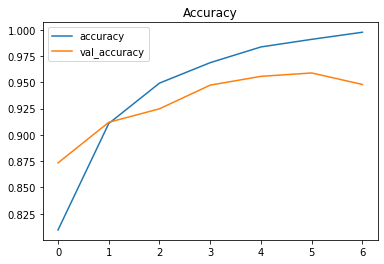

In [150]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

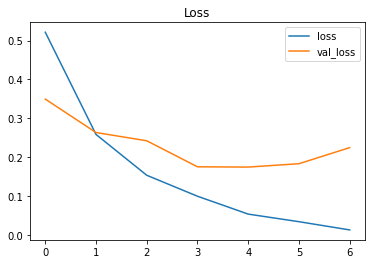

In [151]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [152]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13353
Test Accuracy: 95.84%


In [153]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['dandelion', 'sunflower', 'tulip', 'sunflower', 'daisy']


In [154]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.94      0.97      0.95       157
   dandelion       0.96      0.95      0.96       192
        rose       0.94      0.96      0.95       165
   sunflower       0.98      0.97      0.97       148
       tulip       0.97      0.95      0.96       203

    accuracy                           0.96       865
   macro avg       0.96      0.96      0.96       865
weighted avg       0.96      0.96      0.96       865



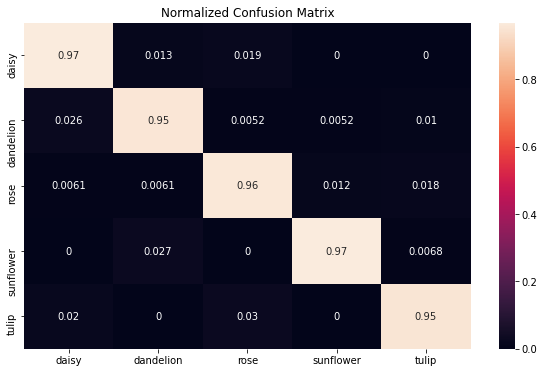

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## 5. Aplicando a implementação em PyTorch ao dataset X

## 6. Comparando os resultados

## 7. Referências

- O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
- Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2016). Densely connected convolutional networks. arXiv preprint arXiv:1608.06993.
- Huang, G., Sun, Y., Liu, Z., Sedra, D., & Weinberger, K. Q. (2016). Deep networks with stochastic depth. In European Conference on Computer Vision (ECCV '16)